# NIRISS Reduction Demo with Grizli
This is a demonstration of reducing the simulated GLASS/NIRISS data from Guido RB using Grizli. The test data I am using are 2 direct images and 2 grism images for the GR150C set of data. These and all other simulated test data are located on AWS-- for access, please contact Gabe Brammer or Victoria Strait. All changes that have been made are now included in the grizli repo here: https://github.com/gbrammer/grizli
### Table of Contents:
* [Set Parameters for Preprocessing](#set-params)
* [Parse Visits](#parse-visits)
* [Run Preprocessing](#run-preprocess)
* [Make Photometric Catalog](#make-phot-cat)
* [Run Contamination Model](#run-contam-model)
* [Extract Spectra](#extract-beams)

In [1]:
# imports and path definitions
import importlib
from importlib import reload

import sys
import os
import glob
import time
import yaml

# grizli stuff
import grizli
import grizli.utils
from grizli.pipeline import auto_script
from grizli import utils, fitting, multifit, prep, model

# python stuff
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from astropy.io import fits
import drizzlepac

utils.set_warnings()

# Make directories
print('GRIZLI_PATH: ', grizli.GRIZLI_PATH)
os.system('export CRDS_PATH="$HOME/crds_cache"')
os.system('export CRDS_SERVER_URL="https://jwst-crds.stsci.edu"')

for sub in ['CONF','iref','jref','templates']:
    dir = os.path.join(grizli.GRIZLI_PATH, sub)
    if not os.path.exists(dir):
        print(f'mkdir {dir}')
        os.mkdir(dir)

for sub in ['iref','jref']:
    if not os.getenv(sub):
        os.environ[sub] = os.path.join(grizli.GRIZLI_PATH, sub) + '/'
    
    print(f'{sub} = {os.getenv(sub)}')

if len(glob.glob(os.path.join(grizli.GRIZLI_PATH, 'CONF/*'))) == 0:
    print('Fetch')
    grizli.utils.fetch_default_calibs(ACS=False) # to iref/iref
    grizli.utils.fetch_config_files()            # to $GRIZLI/CONF

if len(glob.glob(os.path.join(grizli.GRIZLI_PATH, 'templates/*'))) == 0:
    print('link templates')
    grizli.utils.symlink_templates(force=False)
    
%matplotlib inline



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
GRIZLI_PATH:  /Users/victoriastrait/Desktop/grizli_config/
iref = /Users/victoriastrait/Desktop/grizli_config/iref/
jref = /Users/victoriastrait/Desktop/grizli_config/jref/


In [2]:
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)
root = 'jw01324001001'

HOME_PATH =  /Users/victoriastrait/Desktop/niriss/glass-test


In [3]:
# make directories
if not os.path.exists(HOME_PATH + '/' + root + '/RAW'):
    os.chdir(HOME_PATH + '/' + root)
    !mkdir RAW
    os.chdir(HOME_PATH)
if not os.path.exists(HOME_PATH + '/' + root + '/Prep'):
    os.chdir(HOME_PATH + '/' + root)
    !mkdir Prep
    os.chdir(HOME_PATH)
if not os.path.exists(HOME_PATH + '/' + root + '/Extractions'):
    os.chdir(HOME_PATH + '/' + root)
    !mkdir Extractions
    os.chdir(HOME_PATH)

In [4]:
# Let's take a look at the pipeline parameters
from grizli.pipeline.auto_script import get_yml_parameters

# Read the default parameters that can be edited and passed en-masse to `auto_script.go`
kwargs = get_yml_parameters()
print(list(kwargs.keys()))

['HOME_PATH', 'RAW_PATH', 'PREP_PATH', 'PERSIST_PATH', 'EXTRACT_PATH', 'filters', 'fetch_files_args', 'inspect_ramps', 'is_dash', 'run_prepare_dash', 'run_parse_visits', 'is_parallel_field', 'parse_visits_args', 'manual_alignment', 'manual_alignment_args', 'preprocess_args', 'visit_prep_args', 'redo_persistence_mask', 'persistence_args', 'run_fine_alignment', 'fine_backup', 'fine_alignment_args', 'make_mosaics', 'mosaic_args', 'mosaic_drizzle_args', 'mask_spikes', 'mosaic_driz_cr_type', 'make_phot', 'multiband_catalog_args', 'only_preprocess', 'overwrite_fit_params', 'grism_prep_args', 'refine_with_fits', 'run_extractions', 'include_photometry_in_fit', 'make_thumbnails', 'thumb_rgb_params', 'drizzler_args', 'thumbnail_args', 'extract_args']


In [5]:
# Copy default parameters to working directory
default_kwargs = get_yml_parameters(local_file='my_params.yml', copy_defaults=True)

print('\n ---- my_params.yml ---\n')
!head -13 my_params.yml
print('    ...')

Copied default parameter file to my_params.yml

 ---- my_params.yml ---

# Full Grizli pipeline arguments

HOME_PATH: '$PWD'
RAW_PATH: null
PREP_PATH: null
PERSIST_PATH: null
EXTRACT_PATH: null

filters: &filters 
    [F410M, F467M, F547M, F550M, F621M, F689M, F763M, F845M, F200LP, F350LP,
     F435W, F438W, F439W, F450W, F475W, F475X, F555W, F569W, F600LP, F606W,
     F622W, F625W, F675W, F702W, F775W, F791W, F814W, F850LP, G800L, F098M,
     F127M, F139M, F153M, F105W, F110W, F125W, F140W, F160W, G102, G141, F090W, 
    ...


## Set parameters for preprocessing <a class="anchor" id="set-params"></a>

In [6]:
# Preprocessing
# Parameter lists
IS_PARALLEL = False # Set to True for parallel programs like WISPS
visit_prep_args = kwargs['visit_prep_args']
preprocess_args = kwargs['preprocess_args']
#visit_prep_args['fix_stars'] = False

# Maximum shift for "tweakshifts" relative alignment
tweak_max_dist = (5 if IS_PARALLEL else 1)
if 'tweak_max_dist' not in visit_prep_args:
    visit_prep_args['tweak_max_dist'] = tweak_max_dist

# Fit and subtract a SExtractor-like background to each visit
visit_prep_args['imaging_bkg_params']  = {'bh': 256, 'bw': 256, 'fh': 3, 'fw': 3, 
                                          'pixel_scale': 0.1, 'get_median': False}

# Alignment reference catalogs, searched in this order
preprocess_args['catalogs'] = ['PS1','GAIA','SDSS','WISE']
# add webb filters
kwargs['filters']+=['GR150C', 'GR150R', 'F115W', 'F150W', 'F200W']

kwargs['parse_visits_args']['max_dt'] = 1e9 # why is the default 1e9?
#preprocess_args['master_radec'] = '/Users/victoriastrait/Desktop/radec.cat' # took this from gael's catalog
# why are the magnitudes negative? They should be between 13-20... 
visit_prep_args['drizzle_params']['bits'] = 1+2+4+32768+16777216+1048576
visit_prep_args['fix_stars']= False
kwargs['grism_prep_args']['refine_mag_limits'] = [18, 24]

## Parse Visits <a class="anchor" id="parse-visits"></a>
Right now, for NIRISS, this identifies which exposures are direct/grism images, and groups them into associations for processing. This works a bit differently for NIRISS than with HST. For NIRISS, we extract 'FILTER' which is the grism (GR150C or GR150R) and 'PUPIL' which is the direct filter (e.g, F150W) from the header, and match the grism images based on the direct filter. 

This function seems to be working correctly

In [7]:
# Parse visit associations
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
kwargs['parse_visits_args']['combine_same_pa'] = True
#kwargs['parse_visits_args']['isJWST'] = True
visits, all_groups, info = grizli.pipeline.auto_script.parse_visits(field_root=root,
                                                    **kwargs['parse_visits_args'])

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

# (2022-05-24 13:58:07.169)

auto_script.parse_visits(**{'files': [], 'field_root': 'jw01324001001', 'RAW_PATH': '../RAW', 'use_visit': True, 'combine_same_pa': True, 'combine_minexp': 2, 'is_dash': False, 'filters': ['F410M', 'F467M', 'F547M', 'F550M', 'F621M', 'F689M', 'F763M', 'F845M', 'F200LP', 'F350LP', 'F435W', 'F438W', 'F439W', 'F450W', 'F475W', 'F475X', 'F555W', 'F569W', 'F600LP', 'F606W', 'F622W', 'F625W', 'F675W', 'F702W', 'F775W', 'F791W', 'F814W', 'F850LP', 'G800L', 'F098M', 'F127M', 'F139M', 'F153M', 'F105W', 'F110W', 'F125W', 'F140W', 'F160W', 'G102', 'G141', 'F070W', 'F090W', 'F1000W', 'F1130W', 'F115W', 'F1280W', 'F140M', 'F1500W', 'F150W', 'F150W2', 'F158M', 'F162M', 'F164N', 'F1800W', 'F182M', 'F187N', 'F200W', 'F2100W', 'F210M', 'F212N', 'F250M', 'F2550W', 'F277W', 'F300M', 'F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F380M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M', 'F560W', 'F770W', 'GR150C', 'GR150R', 'GRISMR', 'GRISMC'], 'max_dt': 

## Run Preprocessing <a class="anchor" id="run-preprocess"></a>

Let's run the preprocessing script, which will do: 
* File handling (e.g., copying from ./RAW to ./Prep/)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Cosmic ray rejection

#### IMPORTANT: These things are all still being tested. The script runs without errors, but we are not certain that flat-fielding, background subtraction, etc. are working yet. 

In [8]:
#####################
### Alignment & mosaics   
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# This script will do all the preprocessing of the grism *and* imaging visits 
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH,
                       visit_prep_args=visit_prep_args, **preprocess_args)    

# (2022-05-24 13:58:08.345)

auto_script.preprocess(**{'field_root': 'jw01324001001', 'HOME_PATH': '/Users/victoriastrait/Desktop/niriss/glass-test', 'PERSIST_PATH': None, 'min_overlap': 0.2, 'make_combined': False, 'catalogs': ['PS1', 'GAIA', 'SDSS', 'WISE'], 'use_visit': True, 'master_radec': None, 'parent_radec': None, 'use_first_radec': False, 'skip_imaging': False, 'clean': True, 'skip_single_optical_visits': False, 'visit_prep_args': {'align_thresh': None, 'align_rms_limit': 2, 'align_mag_limits': [14, 24, 0.05], 'align_assume_close': False, 'align_ref_border': 100, 'max_err_percentile': 99, 'align_min_flux_radius': 1.0, 'catalog_mask_pad': 0.05, 'match_catalog_density': False, 'drizzle_params': {'bits': 17858567}, 'single_image_CRs': True, 'run_tweak_align': True, 'tweak_threshold': 1.5, 'tweak_fit_order': -1, 'tweak_max_dist': 100, 'tweak_n_min': 10, 'align_simple': False, 'align_clip': 120, 'column_average': True, 'sky_iter': 10, 'iter_atol': 0.0001, 'imaging_bkg_params': {'bh

In [10]:
# The phot catalog code wants filenames in a different format. 
# There is also a function in grizli which creates mosaics that I have not tried using yet
os.system('cp jw01324-000.0-f115w-clear_drz_sci.fits ' + root + '-f115w_drz_sci.fits')
os.system('cp jw01324-000.0-f150w-clear_drz_sci.fits ' + root + '-f150w_drz_sci.fits')
os.system('cp jw01324-000.0-f200w-clear_drz_sci.fits ' + root + '-f200w_drz_sci.fits')

0

### Make a Photometric Catalog <a class="anchor" id="make-phot-cat"></a>
Runs SEP on the mosaicked images and generates a photometric catalog with aperture photometry in all available bands. 

In [11]:
if not os.path.exists('{0}_phot.fits'.format(root)):
    
    multiband_catalog_args=kwargs['multiband_catalog_args']
    tab = auto_script.multiband_catalog(field_root=root, sci_image=root + '-f115w_drz_sci.fits',
                                    **multiband_catalog_args)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

2022-05-24 15:59:26,973 - stpipe - INFO - 
        Inconsistent SIP distortion information is present in the current WCS:
        SIP coefficients were detected, but CTYPE is missing "-SIP" suffix,
        therefore the current WCS is internally inconsistent.

        Because relax has been set to True, the resulting output WCS will have
        "-SIP" appended to CTYPE in order to make the header internally consistent.

        However, this may produce incorrect astrometry in the output WCS, if
        in fact the current WCS is already distortion-corrected.

        Therefore, if current WCS is already distortion-corrected (eg, drizzled)
        then SIP distortion components should not apply. In that case, for a WCS
        that is already distortion-corrected, please remove the SIP coefficients
        from the header.

        


# (2022-05-24 13:59:26.848)

auto_script.multiband_catalog(**{'threshold': 1.0, 'detection_background': True, 'photometry_background': True, 'get_all_filters': False, 'filters': None, 'det_err_scale': -inf, 'phot_err_scale': -inf, 'rescale_weight': False, 'run_detection': True, 'detection_filter': 'ir', 'detection_root': None, 'output_root': None, 'use_psf_filter': True, 'detection_params': {'minarea': 9, 'filter_kernel': array([[0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0687, 0.296 , 0.7105, 0.9511, 0.7105, 0.296 , 0.0687],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049]]), 'filter_type': 'conv', 'clean': True, 'clean_param': 1, 'deblend_nthresh': 32, 'deblend_cont': 0.001}, 'phot_aperture

### Run Contamination Model <a class="anchor" id="run-contam-model"></a>
This creates a contamination model for each grism exposure.

In [12]:
files = glob.glob('*GrismFLT.fits')

if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    grism_prep_args = kwargs['grism_prep_args']
    
    grism_prep_args['gris_ref_filters'] = {'G141': ['F140W', 'F160W'], 
                                           'G102': ['F105W', 'F098M', 'F110W'],
                                           'GR150C': ['F115W', 'F150W', 'F200W'],
                                            'GR150R': ['F115W','F150W', 'F200W']}
    
    grp = auto_script.grism_prep(field_root=root, **grism_prep_args)

 
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

# (2022-05-24 13:59:40.056)

auto_script.grism_prep(**{'field_root': 'jw01324001001', 'PREP_PATH': '../Prep', 'EXTRACT_PATH': '../Extractions', 'ds9': None, 'refine_niter': 3, 'gris_ref_filters': {'G141': ['F140W', 'F160W'], 'G102': ['F105W', 'F098M', 'F110W'], 'GR150C': ['F115W', 'F150W', 'F200W'], 'GR150R': ['F115W', 'F150W', 'F200W']}, 'files': None, 'split_by_grism': True, 'refine_poly_order': 3, 'refine_fcontam': 0.5, 'cpu_count': 0, 'mask_mosaic_edges': True, 'prelim_mag_limit': 25, 'refine_mag_limits': [18, 24], 'grisms_to_process': None})



2022-05-24 15:59:42,130 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 15:59:44,108 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608568396 -30.416013166 3.609022400 -30.378605760 3.565973710 -30.378391365 3.565493333 -30.415772122
2022-05-24 15:59:44,109 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608568396 -30.416013166 3.609022400 -30.378605760 3.565973710 -30.378391365 3.565493333 -30.415772122
2022-05-24 15:59:44,109 - stpipe - INFO - COMPLETED assign_wcs
2022-05-24 15:59:44,683 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 15:59:45,207 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608568396 -30.416013166 3.609022400 -30.378605760 3.565973710 -30.378391365 3.565493333 -30.415772122
2022-05-24 15:59:45,208 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608568396 -30.416013166 3.609022400 -30.378605760 3.565973710 -30.378391365 3.565493333 -30.415772122
2022-05-24 15:59:45,2

Image cutout: x=slice(0, 2067, None), y=slice(0, 2088, None) [Out of range]
jw01324001001_01101_00002_nis_reduced_cluster_rate.fits / blot reference jw01324001001-f115w_drz_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2067, None), y=slice(0, 2088, None) [Out of range]
jw01324001001_01101_00002_nis_reduced_cluster_rate.fits / Pad ref HDU with 565 pixels
jw01324001001_01101_00002_nis_reduced_cluster_rate.fits / blot segmentation jw01324001001-ir_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True


2022-05-24 15:59:47,797 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 15:59:48,459 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608735797 -30.416096619 3.609189802 -30.378689213 3.566141074 -30.378474818 3.565660697 -30.415855575
2022-05-24 15:59:48,460 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608735797 -30.416096619 3.609189802 -30.378689213 3.566141074 -30.378474818 3.565660697 -30.415855575
2022-05-24 15:59:48,460 - stpipe - INFO - COMPLETED assign_wcs
2022-05-24 15:59:49,128 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 15:59:49,667 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608735797 -30.416096619 3.609189802 -30.378689213 3.566141074 -30.378474818 3.565660697 -30.415855575
2022-05-24 15:59:49,668 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608735797 -30.416096619 3.609189802 -30.378689213 3.566141074 -30.378474818 3.565660697 -30.415855575
2022-05-24 15:59:49,6

Image cutout: x=slice(0, 2067, None), y=slice(0, 2088, None) [Out of range]
jw01324001001_01101_00003_nis_reduced_cluster_rate.fits / blot reference jw01324001001-f115w_drz_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2067, None), y=slice(0, 2088, None) [Out of range]
jw01324001001_01101_00003_nis_reduced_cluster_rate.fits / Pad ref HDU with 572 pixels
jw01324001001_01101_00003_nis_reduced_cluster_rate.fits / blot segmentation jw01324001001-ir_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True
Files loaded - 11.47 sec.


2022-05-24 15:59:52,353 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 15:59:53,071 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608568855 -30.416013582 3.609022548 -30.378605409 3.565973331 -30.378390693 3.565492740 -30.415772319
2022-05-24 15:59:53,072 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608568855 -30.416013582 3.609022548 -30.378605409 3.565973331 -30.378390693 3.565492740 -30.415772319
2022-05-24 15:59:53,072 - stpipe - INFO - COMPLETED assign_wcs
2022-05-24 15:59:53,675 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 15:59:54,301 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608568855 -30.416013582 3.609022548 -30.378605409 3.565973331 -30.378390693 3.565492740 -30.415772319
2022-05-24 15:59:54,302 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608568855 -30.416013582 3.609022548 -30.378605409 3.565973331 -30.378390693 3.565492740 -30.415772319
2022-05-24 15:59:54,3

Image cutout: x=slice(0, 2065, None), y=slice(0, 2086, None) [Out of range]
jw01324001001_01101_00022_nis_reduced_cluster_rate.fits / blot reference jw01324001001-f150w_drz_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2067, None), y=slice(0, 2088, None) [Out of range]
jw01324001001_01101_00022_nis_reduced_cluster_rate.fits / Pad ref HDU with 565 pixels
jw01324001001_01101_00022_nis_reduced_cluster_rate.fits / blot segmentation jw01324001001-ir_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True


2022-05-24 15:59:57,045 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 15:59:57,807 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608736255 -30.416097035 3.609189949 -30.378688862 3.566140695 -30.378474146 3.565660104 -30.415855771
2022-05-24 15:59:57,808 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608736255 -30.416097035 3.609189949 -30.378688862 3.566140695 -30.378474146 3.565660104 -30.415855771
2022-05-24 15:59:57,808 - stpipe - INFO - COMPLETED assign_wcs
2022-05-24 15:59:58,386 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 15:59:58,935 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608736255 -30.416097035 3.609189949 -30.378688862 3.566140695 -30.378474146 3.565660104 -30.415855771
2022-05-24 15:59:58,936 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608736255 -30.416097035 3.609189949 -30.378688862 3.566140695 -30.378474146 3.565660104 -30.415855771
2022-05-24 15:59:58,9

Image cutout: x=slice(0, 2065, None), y=slice(0, 2086, None) [Out of range]
jw01324001001_01101_00023_nis_reduced_cluster_rate.fits / blot reference jw01324001001-f150w_drz_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2067, None), y=slice(0, 2088, None) [Out of range]
jw01324001001_01101_00023_nis_reduced_cluster_rate.fits / Pad ref HDU with 573 pixels
jw01324001001_01101_00023_nis_reduced_cluster_rate.fits / blot segmentation jw01324001001-ir_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True
Files loaded - 9.22 sec.


2022-05-24 16:00:01,512 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 16:00:02,075 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608568192 -30.416013554 3.609021253 -30.378606339 3.565973798 -30.378390907 3.565493034 -30.415771725
2022-05-24 16:00:02,076 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608568192 -30.416013554 3.609021253 -30.378606339 3.565973798 -30.378390907 3.565493034 -30.415771725
2022-05-24 16:00:02,077 - stpipe - INFO - COMPLETED assign_wcs
2022-05-24 16:00:02,631 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 16:00:03,270 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608568192 -30.416013554 3.609021253 -30.378606339 3.565973798 -30.378390907 3.565493034 -30.415771725
2022-05-24 16:00:03,271 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608568192 -30.416013554 3.609021253 -30.378606339 3.565973798 -30.378390907 3.565493034 -30.415771725
2022-05-24 16:00:03,2

Image cutout: x=slice(0, 2067, None), y=slice(0, 2088, None) [Out of range]
jw01324001001_01101_00042_nis_reduced_cluster_rate.fits / blot reference jw01324001001-f200w_drz_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2067, None), y=slice(0, 2088, None) [Out of range]
jw01324001001_01101_00042_nis_reduced_cluster_rate.fits / Pad ref HDU with 565 pixels
jw01324001001_01101_00042_nis_reduced_cluster_rate.fits / blot segmentation jw01324001001-ir_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True


2022-05-24 16:00:05,808 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 16:00:06,348 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608735593 -30.416097007 3.609188655 -30.378689793 3.566141163 -30.378474360 3.565660398 -30.415855178
2022-05-24 16:00:06,349 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608735593 -30.416097007 3.609188655 -30.378689793 3.566141163 -30.378474360 3.565660398 -30.415855178
2022-05-24 16:00:06,350 - stpipe - INFO - COMPLETED assign_wcs
2022-05-24 16:00:06,914 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-05-24 16:00:07,426 - stpipe - INFO - Update S_REGION to POLYGON ICRS  3.608735593 -30.416097007 3.609188655 -30.378689793 3.566141163 -30.378474360 3.565660398 -30.415855178
2022-05-24 16:00:07,427 - stpipe - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.608735593 -30.416097007 3.609188655 -30.378689793 3.566141163 -30.378474360 3.565660398 -30.415855178
2022-05-24 16:00:07,4

Image cutout: x=slice(0, 2067, None), y=slice(0, 2088, None) [Out of range]
jw01324001001_01101_00043_nis_reduced_cluster_rate.fits / blot reference jw01324001001-f200w_drz_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 2067, None), y=slice(0, 2088, None) [Out of range]
jw01324001001_01101_00043_nis_reduced_cluster_rate.fits / Pad ref HDU with 573 pixels
jw01324001001_01101_00043_nis_reduced_cluster_rate.fits / blot segmentation jw01324001001-ir_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Transform NIRISS: flip=True
Files loaded - 8.38 sec.
jw01324001001_01101_00003_nis_reduced_cluster_rate.fits: _compute_model Done
jw01324001001_01101_00002_nis_reduced_cluster_rate.fits: _compute_model Done
Models computed - 14.83 sec.
Save jw01324001001_01101_00002_nis_reduced_cluster.01.GrismFLT.fits
Save jw01324001001_01101_00003_nis_reduced_cluster.01.GrismFLT.fits

######################

 1550 mag= 22.01 -2.28e-18  5.49e-17 -3.17e-16  5.90e-16
 1292 mag= 22.11  4.07e-19  5.38e-18 -4.41e-17  1.10e-16
  672 mag= 22.12  1.99e-18  8.32e-19 -3.00e-17  7.55e-17
  951 mag= 22.12  1.66e-18 -2.13e-17  1.72e-16 -5.80e-16
  536 mag= 22.14 -2.46e-20  6.38e-19 -4.32e-18  8.61e-18
 1066 mag= 22.15  1.33e-20 -4.71e-19  3.78e-18 -8.00e-18
  201 mag= 22.18  1.86e-18 -2.18e-17  1.24e-16 -2.37e-16
 1302 mag= 22.20  1.48e-18  5.47e-18 -1.19e-16  3.11e-16
  630 mag= 22.27  1.88e-18 -3.05e-17  2.22e-16 -4.69e-16
 1472 mag= 22.28  2.67e-19  1.60e-17 -2.56e-16  8.69e-16 xx
  469 mag= 22.28 -1.98e-18  5.84e-17 -3.56e-16  6.07e-16
  757 mag= 22.28 -6.81e-18  1.73e-16 -1.16e-15  2.38e-15
 1056 mag= 22.32 -2.43e-19  1.24e-17 -5.29e-17  6.74e-17
  910 mag= 22.32 -2.59e-19  2.15e-17 -1.44e-16  2.99e-16
 1474 mag= 22.35  2.05e-18 -2.47e-17  1.40e-16 -3.55e-16
  275 mag= 22.35  1.39e-18 -2.36e-17  1.78e-16 -4.33e-16
  852 mag= 22.35  1.41e-18 -9.79e-18  5.15e-17 -9.60e-17
  965 mag= 22.40  4.68e-19  

  801 mag= 23.73  4.79e-20  1.84e-18 -7.33e-18  2.49e-18
  632 mag= 23.73 -6.18e-20  5.79e-18 -4.17e-17  9.09e-17
  443 mag= 23.73  5.74e-20  1.61e-18 -9.74e-18  1.72e-17
  523 mag= 23.74 -2.00e-19  5.72e-18 -3.12e-17  5.68e-17
  312 mag= 23.74  2.84e-20  3.17e-18 -2.05e-17  4.07e-17
  678 mag= 23.75  6.12e-20 -9.02e-19  1.99e-17 -4.96e-17
  717 mag= 23.77  1.77e-19  1.14e-18 -1.22e-17  3.01e-17
  909 mag= 23.77 -1.28e-19  4.30e-18 -2.03e-17  3.28e-17
  407 mag= 23.77  3.13e-20  7.02e-19 -2.60e-18  1.12e-18
  749 mag= 23.79  5.23e-20  1.57e-18 -1.14e-17  2.33e-17
  545 mag= 23.79  2.99e-19 -4.02e-18  2.56e-17 -5.11e-17
  272 mag= 23.80  4.33e-19 -3.56e-18  1.89e-17 -3.57e-17
 1506 mag= 23.81  1.76e-19 -1.05e-18  8.24e-18 -2.00e-17
 1325 mag= 23.81  6.97e-19  5.86e-18 -1.14e-16  3.11e-16
 1003 mag= 23.82  1.91e-20  8.83e-19 -5.29e-18  9.16e-18
  814 mag= 23.82 -2.80e-20  6.35e-19  3.93e-18 -1.35e-17
  308 mag= 23.83 -7.02e-20  6.42e-18 -8.51e-17  3.70e-16
  639 mag= 23.85  2.18e-19 -1.3

 1281 mag= 21.98  1.27e-18 -9.78e-18  6.28e-17 -1.31e-16
 1550 mag= 22.01 -2.21e-18  5.35e-17 -3.09e-16  5.72e-16
 1292 mag= 22.11  5.11e-19  3.06e-18 -2.77e-17  7.27e-17
  672 mag= 22.12  1.99e-18  8.38e-19 -3.00e-17  7.55e-17
  951 mag= 22.12  1.25e-18  1.38e-18 -8.25e-17  2.27e-16
  536 mag= 22.14 -2.47e-20  6.37e-19 -4.31e-18  8.60e-18
 1066 mag= 22.15  1.31e-20 -4.69e-19  3.77e-18 -7.99e-18
  201 mag= 22.18  1.86e-18 -2.18e-17  1.25e-16 -2.39e-16
 1302 mag= 22.20  1.65e-18  1.64e-18 -9.37e-17  2.60e-16
  630 mag= 22.27  1.64e-18 -2.20e-17  1.58e-16 -3.35e-16
 1472 mag= 22.28  3.84e-19  1.40e-17 -2.10e-16  6.77e-16
  469 mag= 22.28 -2.01e-18  5.35e-17 -2.93e-16  4.06e-16
  757 mag= 22.28 -6.77e-18  1.72e-16 -1.15e-15  2.37e-15
 1056 mag= 22.32 -4.40e-19  1.66e-17 -7.88e-17  1.21e-16
  910 mag= 22.32 -2.67e-19  2.15e-17 -1.44e-16  2.97e-16
 1474 mag= 22.35  1.73e-18 -1.12e-17  1.25e-17 -2.99e-17
  275 mag= 22.35  1.31e-18 -1.50e-17  8.51e-17 -1.69e-16
  852 mag= 22.35  1.71e-18 -1.4

 1097 mag= 23.72 -2.97e-20  3.27e-18 -2.24e-17  4.60e-17
  801 mag= 23.73  1.99e-19 -1.21e-18  1.43e-17 -4.68e-17
  632 mag= 23.73 -8.54e-20  6.17e-18 -3.95e-17  7.80e-17
  443 mag= 23.73  5.74e-20  1.61e-18 -9.74e-18  1.72e-17
  523 mag= 23.74 -1.98e-19  5.67e-18 -3.08e-17  5.60e-17
  312 mag= 23.74  2.78e-20  3.19e-18 -2.07e-17  4.11e-17
  678 mag= 23.75  6.39e-20 -8.26e-19  1.94e-17 -4.84e-17
  717 mag= 23.77  1.77e-19  1.13e-18 -1.21e-17  2.99e-17
  909 mag= 23.77 -1.50e-19  4.84e-18 -2.37e-17  3.96e-17
  407 mag= 23.77  3.56e-20  7.40e-19 -3.10e-18  2.54e-18
  749 mag= 23.79  5.50e-20  1.51e-18 -1.09e-17  2.24e-17
  545 mag= 23.79  3.01e-19 -4.07e-18  2.60e-17 -5.17e-17
  272 mag= 23.80  4.36e-19 -3.64e-18  1.98e-17 -3.81e-17
 1506 mag= 23.81  1.57e-19 -7.39e-19  7.01e-18 -1.92e-17
 1325 mag= 23.81  1.42e-19  1.83e-17 -1.93e-16  4.63e-16
 1003 mag= 23.82  2.00e-20  8.65e-19 -5.16e-18  8.86e-18
  814 mag= 23.82  4.03e-21  6.64e-20  7.17e-18 -1.95e-17
  308 mag= 23.83 -6.83e-20  6.3

 1281 mag= 21.98  1.27e-18 -9.78e-18  6.28e-17 -1.31e-16
 1550 mag= 22.01 -2.21e-18  5.35e-17 -3.09e-16  5.72e-16
 1292 mag= 22.11  5.12e-19  3.04e-18 -2.76e-17  7.25e-17
  672 mag= 22.12  1.99e-18  8.35e-19 -3.00e-17  7.55e-17
  951 mag= 22.12  1.25e-18  1.51e-18 -8.36e-17  2.29e-16
  536 mag= 22.14 -2.47e-20  6.37e-19 -4.31e-18  8.60e-18
 1066 mag= 22.15  1.31e-20 -4.69e-19  3.77e-18 -7.99e-18
  201 mag= 22.18  2.02e-18 -2.51e-17  1.45e-16 -2.78e-16
 1302 mag= 22.20  1.67e-18  1.34e-18 -9.19e-17  2.57e-16
  630 mag= 22.27  1.29e-18 -1.86e-17  1.42e-16 -3.10e-16
 1472 mag= 22.28  3.62e-19  1.39e-17 -1.98e-16  6.17e-16
  469 mag= 22.28 -2.00e-18  5.32e-17 -2.90e-16  4.01e-16
  757 mag= 22.28 -6.77e-18  1.72e-16 -1.15e-15  2.37e-15
 1056 mag= 22.32 -4.93e-19  1.75e-17 -8.41e-17  1.32e-16
  910 mag= 22.32 -2.66e-19  2.15e-17 -1.44e-16  2.97e-16
 1474 mag= 22.35  1.72e-18 -1.01e-17 -2.44e-19  4.99e-18
  275 mag= 22.35  1.48e-18 -1.97e-17  1.25e-16 -2.73e-16
  852 mag= 22.35  1.71e-18 -1.4

 1455 mag= 23.69 -4.94e-20 -7.36e-18  7.65e-17 -1.93e-16 xx
  452 mag= 23.70  2.32e-19  4.41e-19 -7.45e-18  1.81e-17
 1097 mag= 23.72 -2.97e-20  3.27e-18 -2.24e-17  4.60e-17
  801 mag= 23.73  1.94e-19 -9.01e-19  1.21e-17 -4.23e-17
  632 mag= 23.73 -5.17e-20  5.42e-18 -3.48e-17  6.86e-17
  443 mag= 23.73  5.74e-20  1.61e-18 -9.74e-18  1.72e-17
  523 mag= 23.74 -1.98e-19  5.67e-18 -3.08e-17  5.60e-17
  312 mag= 23.74  2.78e-20  3.19e-18 -2.07e-17  4.11e-17
  678 mag= 23.75  6.41e-20 -8.25e-19  1.94e-17 -4.83e-17
  717 mag= 23.77  1.76e-19  1.15e-18 -1.23e-17  3.02e-17
  909 mag= 23.77 -1.50e-19  4.84e-18 -2.37e-17  3.96e-17
  407 mag= 23.77  3.56e-20  7.40e-19 -3.10e-18  2.54e-18
  749 mag= 23.79  5.50e-20  1.51e-18 -1.09e-17  2.24e-17
  545 mag= 23.79  3.01e-19 -4.07e-18  2.60e-17 -5.17e-17
  272 mag= 23.80  4.37e-19 -3.65e-18  1.98e-17 -3.81e-17
 1506 mag= 23.81  1.47e-19 -5.35e-19  5.75e-18 -1.69e-17
 1325 mag= 23.81  1.81e-20  2.00e-17 -2.00e-16  4.72e-16
 1003 mag= 23.82  2.00e-20  

 1555 mag= 20.50  1.15e-17 -5.94e-17  1.19e-16 -8.02e-17
 1180 mag= 20.51 -1.85e-18  4.35e-17 -1.40e-16  1.31e-16
 1499 mag= 20.52  1.80e-17 -8.76e-17  1.62e-16 -1.01e-16
  423 mag= 20.52  1.76e-17 -9.09e-17  1.69e-16 -1.05e-16
  979 mag= 20.52  1.73e-16 -1.08e-15  2.24e-15 -1.52e-15
 1489 mag= 20.53 -2.79e-19 -5.79e-18  2.52e-17 -2.51e-17 xx
  950 mag= 20.53 -4.26e-16  2.16e-15 -3.65e-15  2.04e-15 xx
Except: covar!
 1332 mag= 20.55  1.22e-17 -7.62e-17  1.58e-16 -1.10e-16 xx
 1475 mag= 20.55  4.71e-17 -2.59e-16  5.00e-16 -3.21e-16
 1032 mag= 20.57 -7.50e-18  7.14e-17 -1.65e-16  1.22e-16
 1508 mag= 20.57 -6.63e-17  4.26e-16 -8.83e-16  5.95e-16
 1510 mag= 20.58  6.07e-17 -4.01e-16  8.85e-16 -6.44e-16
  888 mag= 20.60 -2.71e-16  1.66e-15 -3.32e-15  2.20e-15
  490 mag= 20.66 -1.86e-19  1.56e-17 -3.35e-17  2.08e-17
  745 mag= 20.66 -5.21e-15  4.33e-14 -1.20e-13  1.11e-13
  774 mag= 20.66 -1.81e-14  8.49e-14 -1.33e-13  6.92e-14 xx
 1233 mag= 20.67 -8.57e-18  5.11e-17 -9.45e-17  5.73e-17
 128

  194 mag= 22.74  1.91e-18 -9.21e-18  1.60e-17 -9.14e-18
  605 mag= 22.77  9.81e-18 -5.79e-17  1.18e-16 -8.09e-17
  768 mag= 22.78  1.97e-19  1.45e-18 -5.20e-18  4.50e-18
 1451 mag= 22.78  1.66e-19  1.06e-18 -2.24e-18  1.16e-18
  513 mag= 22.80  4.93e-18 -2.21e-17  3.42e-17 -1.66e-17
 1315 mag= 22.81 -2.70e-18  1.96e-17 -4.15e-17  2.81e-17
  970 mag= 22.82  2.04e-17 -1.14e-16  2.12e-16 -1.30e-16
  718 mag= 22.86  2.34e-18 -1.28e-17  2.61e-17 -1.79e-17
  282 mag= 22.86  1.24e-18 -5.52e-18  1.07e-17 -7.26e-18
   95 mag= 22.87 -2.98e-18  1.80e-17 -3.49e-17  2.22e-17
 1456 mag= 22.88 -1.57e-20  7.46e-19 -2.87e-18  2.70e-18 xx
  939 mag= 22.88  6.45e-19 -2.51e-18  5.97e-18 -4.68e-18
  822 mag= 22.89  1.59e-18 -1.50e-18 -4.71e-18  5.53e-18
  479 mag= 22.89  1.79e-18 -9.11e-18  1.79e-17 -1.20e-17
  388 mag= 22.89  7.30e-18 -4.43e-17  9.08e-17 -6.15e-17
  206 mag= 22.90 -1.65e-18  8.80e-18 -1.45e-17  7.72e-18
 1141 mag= 22.92  4.47e-20  2.61e-19  1.44e-18 -2.51e-18
 1337 mag= 22.92  4.12e-18 -

 1370 mag= 19.19  2.64e-17 -1.32e-16  2.19e-16 -1.21e-16
 1369 mag= 19.19 -3.04e-18  2.49e-17 -6.77e-17  5.99e-17 xx
 1577 mag= 19.19 -1.25e-18  1.14e-17 -2.20e-17  1.33e-17
  775 mag= 19.20 -2.13e-16  1.46e-15 -3.01e-15  2.03e-15
 1235 mag= 19.23 -2.38e-17  1.44e-16 -2.78e-16  1.75e-16
 1232 mag= 19.25 -4.16e-17  2.53e-16 -5.16e-16  3.47e-16 xx
 1055 mag= 19.28 -1.17e-16  7.17e-16 -1.30e-15  7.58e-16
  914 mag= 19.34  2.83e-16 -1.76e-15  3.69e-15 -2.51e-15
  489 mag= 19.37  3.39e-16 -2.36e-15  5.44e-15 -4.10e-15
  990 mag= 19.37 -3.64e-16  2.55e-15 -5.84e-15  4.39e-15
  193 mag= 19.40  9.22e-17 -5.09e-16  1.03e-15 -6.98e-16
  989 mag= 19.41 -9.31e-17  6.33e-16 -1.41e-15  1.04e-15
  488 mag= 19.45 -9.14e-16  5.28e-15 -1.00e-14  6.24e-15
  949 mag= 19.48  4.38e-16 -2.29e-15  4.00e-15 -2.26e-15
  514 mag= 19.49  2.40e-16 -1.35e-15  2.57e-15 -1.61e-15
 1405 mag= 19.51  2.04e-16 -1.25e-15  2.62e-15 -1.82e-15
  985 mag= 19.51  1.16e-17 -4.06e-17  1.63e-16 -1.78e-16
  946 mag= 19.52 -2.36e+0

  467 mag= 21.57 -4.40e-16  3.23e-15 -7.82e-15  6.26e-15
  982 mag= 21.62 -2.23e-18  1.49e-17 -2.13e-17  7.92e-18
  414 mag= 21.62  1.37e-18 -1.87e-18  2.06e-18 -1.17e-18
 1439 mag= 21.64 -2.66e-18  2.67e-17 -6.87e-17  5.52e-17
 1339 mag= 21.64  3.24e-18 -2.00e-17  4.00e-17 -2.62e-17 xx
 1103 mag= 21.65 -4.93e-18  3.96e-17 -8.58e-17  5.91e-17
  420 mag= 21.66  7.72e-18 -4.07e-17  7.94e-17 -5.20e-17
  832 mag= 21.67  3.88e-17 -2.45e-16  4.84e-16 -3.06e-16 xx
  815 mag= 21.71  1.74e-18 -2.24e-18  7.52e-19  8.24e-19
  874 mag= 21.73 -1.04e-18  1.46e-17 -3.16e-17  2.00e-17
  958 mag= 21.74  4.12e+01 -2.68e+02  5.90e+02 -4.31e+02 xx
 1409 mag= 21.74 -3.65e-18  2.29e-17 -3.80e-17  1.89e-17
 1309 mag= 21.74 -9.32e-18  8.37e-17 -2.14e-16  1.78e-16
 1099 mag= 21.77  5.15e-18 -2.85e-17  5.75e-17 -3.80e-17
    2 mag= 21.78  6.35e-19 -3.47e-18  6.81e-18 -4.34e-18 xx
  468 mag= 21.79 -2.04e-18  9.18e-18 -5.66e-18 -4.86e-18
 1382 mag= 21.79  2.35e-18 -1.41e-18 -1.05e-17  1.42e-17
 1081 mag= 21.80 -6

 1554 mag= 23.42 -1.37e-18  9.87e-18 -2.18e-17  1.54e-17
  430 mag= 23.42  1.03e-19  1.60e-18 -4.84e-18  3.69e-18
 1514 mag= 23.43  7.56e-19 -4.19e-18  9.00e-18 -6.41e-18
   89 mag= 23.45  1.33e-18 -7.27e-18  1.39e-17 -8.76e-18
  929 mag= 23.46 -7.20e-18  4.59e-17 -9.57e-17  6.57e-17
 1177 mag= 23.47  1.54e-17 -8.88e-17  1.70e-16 -1.07e-16
 1126 mag= 23.48  1.76e-18 -1.04e-17  2.05e-17 -1.26e-17
 1082 mag= 23.49  4.56e-18 -2.86e-17  6.01e-17 -4.13e-17
 1376 mag= 23.51 -9.84e-19  7.33e-18 -1.64e-17  1.18e-17
  288 mag= 23.52 -6.64e-20  1.29e-18 -2.41e-18  1.15e-18
 1491 mag= 23.54  1.42e-18 -7.24e-18  1.34e-17 -8.31e-18
 1022 mag= 23.54 -1.82e-16  1.42e-15 -3.69e-15  3.19e-15 xx
  643 mag= 23.54 -4.84e-18  3.22e-17 -6.86e-17  4.76e-17
 1511 mag= 23.55  8.30e-19 -2.65e-18  3.58e-18 -1.43e-18
  803 mag= 23.55 -4.43e-19  3.63e-18 -8.05e-18  5.67e-18
 1443 mag= 23.56  2.65e-18 -1.70e-17  3.70e-17 -2.65e-17
  987 mag= 23.57 -2.94e-18  1.71e-17 -2.98e-17  1.63e-17
  698 mag= 23.57 -4.25e-18  

  834 mag= 20.33 -1.17e-17  7.24e-17 -1.47e-16  9.84e-17
  644 mag= 20.34  4.49e-16 -2.67e-15  5.25e-15 -3.39e-15
   73 mag= 20.37 -2.76e-17  1.91e-16 -3.98e-16  2.68e-16
 1534 mag= 20.38  1.02e-17 -6.24e-17  1.24e-16 -8.09e-17 xx
  465 mag= 20.40 -5.14e-16  2.43e-15 -3.39e-15  1.33e-15 xx
   74 mag= 20.42  7.93e-18 -2.87e-17  4.37e-17 -2.01e-17
  670 mag= 20.45 -1.44e-17  1.31e-16 -3.03e-16  2.24e-16
 1555 mag= 20.50  8.50e-18 -4.10e-17  8.04e-17 -5.35e-17
 1180 mag= 20.51  1.11e-17 -1.71e-17 -6.96e-17  1.26e-16
 1499 mag= 20.52  1.79e-17 -8.72e-17  1.61e-16 -1.00e-16
  423 mag= 20.52 -1.20e-18  1.61e-17 -3.51e-17  2.39e-17
  979 mag= 20.52  2.01e-16 -1.26e-15  2.63e-15 -1.79e-15
 1489 mag= 20.53 -6.65e-19 -3.21e-18  1.97e-17 -2.12e-17 xx
  950 mag= 20.53  9.53e-17 -5.60e-16  1.05e-15 -6.43e-16 xx
 1332 mag= 20.55  2.27e-18 -1.49e-17  3.46e-17 -2.65e-17
 1475 mag= 20.55  4.42e-17 -2.42e-16  4.67e-16 -3.00e-16
 1032 mag= 20.57 -6.95e-18  6.83e-17 -1.59e-16  1.19e-16
 1508 mag= 20.57 -1

 1504 mag= 22.70  1.67e-18 -1.14e-17  2.79e-17 -2.19e-17
 1564 mag= 22.71  4.26e-18 -2.77e-17  5.89e-17 -4.13e-17 xx
 1422 mag= 22.71 -1.99e-20  1.14e-18 -2.84e-18  2.36e-18
 1345 mag= 22.73  1.43e-18 -3.12e-18 -1.93e-19  2.92e-18
 1194 mag= 22.73  9.99e-18 -6.18e-17  1.29e-16 -8.78e-17
  194 mag= 22.74  2.00e-18 -9.78e-18  1.72e-17 -1.00e-17
  605 mag= 22.77  8.83e-18 -5.17e-17  1.06e-16 -7.24e-17
  768 mag= 22.78 -1.63e-20  2.80e-18 -7.86e-18  6.15e-18
 1451 mag= 22.78 -1.43e-19  2.92e-18 -5.86e-18  3.45e-18
  513 mag= 22.80  4.93e-18 -2.21e-17  3.42e-17 -1.66e-17
 1315 mag= 22.81 -2.71e-18  1.97e-17 -4.16e-17  2.81e-17
  970 mag= 22.82  2.06e-17 -1.16e-16  2.16e-16 -1.32e-16
  718 mag= 22.86  2.34e-18 -1.28e-17  2.60e-17 -1.78e-17
  282 mag= 22.86  1.24e-18 -5.52e-18  1.07e-17 -7.26e-18
   95 mag= 22.87 -2.97e-18  1.80e-17 -3.47e-17  2.21e-17
 1456 mag= 22.88 -3.21e-20  7.39e-19 -2.62e-18  2.38e-18 xx
  939 mag= 22.88  6.45e-19 -2.52e-18  5.98e-18 -4.69e-18
  822 mag= 22.89  1.91e-1

# grism_mode_bg jw01324001001_01101_00043_nis_reduced_cluster_rate.fits GR150C 0.0091
# (2022-05-24 14:03:42.590)
# Refine contamination

Refine contamination model, iter # 0

 1556 mag= 18.44 -1.40e-17  4.41e-17 -4.60e-17  1.59e-17 xx
 1524 mag= 18.56  9.05e-18 -2.60e-17  2.46e-17 -7.67e-18 xx
 1433 mag= 18.68  7.75e-17 -2.38e-16  2.39e-16 -7.93e-17 xx
  466 mag= 18.80 -9.38e+00  2.70e+01 -2.58e+01  8.18e+00 xx
  464 mag= 18.84 -5.07e-17  1.48e-16 -1.43e-16  4.59e-17
 1441 mag= 18.89  5.10e-18 -1.66e-17  1.81e-17 -6.54e-18
 1234 mag= 18.91  2.02e-15 -6.13e-15  6.19e-15 -2.07e-15
  577 mag= 18.96  3.01e-17 -8.15e-17  9.42e-17 -3.75e-17
 1473 mag= 18.97 -2.40e-16  7.23e-16 -6.95e-16  2.21e-16
  799 mag= 18.97 -5.49e-16  1.80e-15 -1.92e-15  6.77e-16
  773 mag= 18.97  1.34e-17 -3.42e-17  3.35e-17 -1.09e-17
  776 mag= 19.04 -3.54e-17  1.12e-16 -1.11e-16  3.63e-17
  913 mag= 19.05 -3.36e-18  7.48e-18 -4.73e-18  6.73e-19
 1444 mag= 19.16 -1.25e-17  5.34e-17 -4.34e-17  1.04e-17
 1370 mag= 19.

  870 mag= 21.32 -3.56e-18  1.23e-17 -1.10e-17  3.06e-18
  816 mag= 21.33  2.09e-17 -5.83e-17  5.74e-17 -1.91e-17
 1050 mag= 21.35 -8.10e-18  2.95e-17 -3.19e-17  1.12e-17
  942 mag= 21.38  2.33e-16 -6.45e-16  5.92e-16 -1.80e-16
 1051 mag= 21.38  6.95e-18 -1.81e-17  1.77e-17 -5.91e-18
  531 mag= 21.39  2.38e-17 -7.06e-17  7.33e-17 -2.54e-17
 1308 mag= 21.43 -2.34e-16  8.85e-16 -1.11e-15  4.66e-16 xx
 1505 mag= 21.44  9.13e-18 -2.96e-17  3.27e-17 -1.19e-17
  817 mag= 21.47 -7.83e-18  2.98e-17 -3.30e-17  1.18e-17
 1381 mag= 21.50  8.23e-18 -2.36e-17  2.45e-17 -8.50e-18
 1460 mag= 21.52  3.34e-17 -9.65e-17  9.15e-17 -2.85e-17 xx
  894 mag= 21.52  3.36e-16 -9.80e-16  9.50e-16 -3.06e-16
  700 mag= 21.53  2.93e-18 -5.82e-18  5.03e-18 -1.39e-18
  835 mag= 21.56 -9.58e-17  3.15e-16 -3.44e-16  1.25e-16 xx
  467 mag= 21.57  9.07e-16 -2.96e-15  3.15e-15 -1.09e-15 xx
  982 mag= 21.62 -2.64e-17  8.37e-17 -8.65e-17  2.97e-17
  414 mag= 21.62  2.68e-18 -6.56e-18  6.94e-18 -2.54e-18
 1439 mag= 21.64  9

  177 mag= 23.36  1.92e-18 -5.75e-18  6.05e-18 -2.12e-18
   30 mag= 23.36 -6.40e-19  2.24e-18 -2.62e-18  1.01e-18 xx
 1004 mag= 23.37 -2.44e-17  8.05e-17 -8.65e-17  3.03e-17 xx
  211 mag= 23.37  6.45e-19 -1.39e-18  1.07e-18 -2.47e-19
  853 mag= 23.37  7.61e-19 -2.43e-18  2.50e-18 -8.52e-19 xx
  200 mag= 23.38  2.25e-19 -8.31e-19  1.15e-18 -4.99e-19
   79 mag= 23.38 -5.46e-18  1.96e-17 -2.03e-17  6.83e-18
  988 mag= 23.40 -6.02e-18  1.75e-17 -1.60e-17  4.76e-18
 1554 mag= 23.42  1.08e-18 -3.84e-18  4.31e-18 -1.59e-18 xx
  430 mag= 23.42  3.34e-19 -2.81e-19 -1.07e-21  3.52e-20
 1514 mag= 23.43 -4.39e-18  1.49e-17 -1.64e-17  5.96e-18
   89 mag= 23.45  3.46e-18 -1.01e-17  1.00e-17 -3.30e-18
  929 mag= 23.46 -5.30e-18  1.77e-17 -2.01e-17  7.70e-18
 1177 mag= 23.47  1.08e-16 -3.40e-16  3.48e-16 -1.17e-16
 1126 mag= 23.48  6.45e-19 -3.12e-18  4.49e-18 -1.83e-18
 1082 mag= 23.49 -8.16e-19  6.27e-18 -9.89e-18  4.37e-18 xx
 1376 mag= 23.51 -1.00e-18  3.34e-18 -3.47e-18  1.19e-18
  288 mag= 23.52

  915 mag= 20.28  9.50e-17 -2.95e-16  3.05e-16 -1.04e-16
  744 mag= 20.28  1.21e-13 -2.98e-13  2.44e-13 -6.68e-14
 1149 mag= 20.29 -5.62e-16  1.68e-15 -1.66e-15  5.40e-16
  831 mag= 20.33  7.83e+01 -2.28e+02  2.20e+02 -7.03e+01
  834 mag= 20.33 -2.41e-16  7.20e-16 -7.03e-16  2.27e-16
  644 mag= 20.34 -3.71e-16  1.28e-15 -1.47e-15  5.56e-16
   73 mag= 20.37  5.24e-17 -1.53e-16  1.52e-16 -5.06e-17
 1534 mag= 20.38 -1.63e-17  4.99e-17 -5.13e-17  1.76e-17 xx
  465 mag= 20.40  7.27e-19 -3.23e-18  4.41e-18 -1.85e-18
   74 mag= 20.42 -5.93e-17  1.92e-16 -2.01e-16  6.99e-17
  670 mag= 20.45  4.78e-17 -1.39e-16  1.41e-16 -4.81e-17
 1555 mag= 20.50  8.23e-17 -2.57e-16  2.70e-16 -9.45e-17
 1180 mag= 20.51  1.15e-20  4.76e-18 -2.14e-18 -4.56e-19
 1499 mag= 20.52  2.55e-17 -6.94e-17  6.70e-17 -2.17e-17
  423 mag= 20.52  1.21e-17 -3.57e-17  3.53e-17 -1.16e-17
  979 mag= 20.52  2.28e-16 -7.14e-16  7.46e-16 -2.58e-16
 1489 mag= 20.53  1.38e-17 -4.39e-17  4.51e-17 -1.52e-17 xx
  950 mag= 20.53  3.76e-0

 1564 mag= 22.71  3.95e-17 -1.21e-16  1.23e-16 -4.13e-17
 1422 mag= 22.71  1.54e-18 -3.74e-18  3.02e-18 -7.44e-19
 1345 mag= 22.73 -1.11e-17  3.40e-17 -3.35e-17  1.09e-17
 1194 mag= 22.73 -1.10e-18  4.33e-18 -4.98e-18  1.88e-18
  194 mag= 22.74  7.36e-18 -2.25e-17  2.33e-17 -7.96e-18
  605 mag= 22.77  1.88e-17 -5.46e-17  5.43e-17 -1.82e-17
  768 mag= 22.78  7.11e-18 -2.18e-17  2.24e-17 -7.59e-18
 1451 mag= 22.78 -3.31e-19  2.32e-18 -2.93e-18  1.13e-18
  513 mag= 22.80 -9.87e-18  3.03e-17 -2.93e-17  9.34e-18
 1315 mag= 22.81 -2.60e-17  8.38e-17 -8.88e-17  3.11e-17
  970 mag= 22.82  3.89e-17 -1.17e-16  1.16e-16 -3.77e-17
  718 mag= 22.86  8.39e-19 -1.20e-18  3.90e-19  1.27e-19
   95 mag= 22.87  1.79e-18 -5.79e-18  6.43e-18 -2.34e-18
 1456 mag= 22.88 -6.73e-18  2.05e-17 -2.06e-17  6.83e-18
  939 mag= 22.88  1.89e-18 -6.05e-18  6.83e-18 -2.50e-18
  822 mag= 22.89  1.72e-19  3.54e-18 -5.93e-18  2.38e-18
  479 mag= 22.89  1.31e-18 -3.28e-18  3.16e-18 -1.06e-18
  388 mag= 22.89  1.29e-19 -8.9

 1235 mag= 19.23 -1.50e-16  4.49e-16 -4.44e-16  1.45e-16
 1232 mag= 19.25 -2.44e-16  7.55e-16 -7.84e-16  2.71e-16 xx
 1055 mag= 19.28  1.87e-16 -5.38e-16  5.32e-16 -1.75e-16
  914 mag= 19.34 -1.93e-17  5.60e-17 -5.33e-17  1.66e-17 xx
  489 mag= 19.37 -1.35e-16  4.35e-16 -4.51e-16  1.54e-16
  990 mag= 19.37  1.85e-16 -6.26e-16  6.91e-16 -2.47e-16
  193 mag= 19.40 -2.94e-17  1.14e-16 -1.23e-16  4.27e-17
  989 mag= 19.41 -2.91e-16  9.35e-16 -9.84e-16  3.40e-16 xx
  488 mag= 19.45 -9.52e-17  3.06e-16 -3.08e-16  1.02e-16
  949 mag= 19.48  2.32e-17 -5.18e-17  3.70e-17 -8.42e-18 xx
  514 mag= 19.49  1.93e-17 -3.58e-17  2.64e-17 -6.63e-18
  872 mag= 19.50 -5.33e+01  2.50e+02 -3.79e+02  1.75e+02 xx
 1405 mag= 19.51 -2.19e-16  6.93e-16 -7.07e-16  2.38e-16
  985 mag= 19.51 -5.49e-16  1.70e-15 -1.72e-15  5.75e-16
  946 mag= 19.52 -2.29e+02  7.75e+02 -8.93e+02  3.40e+02 xx
  919 mag= 19.58 -2.96e-01  5.62e-01 -2.58e-01 -1.75e-02 xx
 1521 mag= 19.58 -1.81e-18  4.46e-18 -3.24e-18  6.73e-19
 1461 mag=

  874 mag= 21.73 -6.55e+02  1.74e+03 -1.55e+03  4.59e+02 xx
  958 mag= 21.74 -1.31e+02  4.23e+02 -4.45e+02  1.53e+02 xx
 1409 mag= 21.74  3.63e-18 -9.55e-18  9.73e-18 -3.40e-18
 1099 mag= 21.77 -3.09e-17  9.63e-17 -9.80e-17  3.30e-17
    2 mag= 21.78 -6.13e-20 -3.47e-20  2.48e-19 -1.42e-19
  468 mag= 21.79  1.36e-18  5.56e-18 -1.60e-17  9.07e-18
 1382 mag= 21.79 -5.91e-17  1.79e-16 -1.78e-16  5.86e-17
 1081 mag= 21.80 -2.08e-18  6.40e-18 -6.47e-18  2.15e-18
 1045 mag= 21.81 -1.18e-16  3.69e-16 -3.76e-16  1.25e-16
 1335 mag= 21.83  1.51e-17 -4.46e-17  4.41e-17 -1.45e-17
 1070 mag= 21.87  1.14e-17 -3.41e-17  3.58e-17 -1.26e-17
  626 mag= 21.91 -1.53e+01  3.98e+01 -3.47e+01  1.00e+01 xx
  530 mag= 21.92  4.20e-18 -1.11e-17  1.13e-17 -3.94e-18
  836 mag= 21.92  2.61e-14 -6.40e-14  5.23e-14 -1.42e-14
  991 mag= 21.94 -4.65e-17  1.82e-16 -2.22e-16  8.64e-17 xx
 1281 mag= 21.98 -9.65e-19  4.71e-18 -5.31e-18  1.88e-18
 1320 mag= 22.00  2.34e-17 -6.79e-17  6.58e-17 -2.12e-17
 1550 mag= 22.01 -7

  698 mag= 23.57 -2.71e-18 -7.38e-19  8.37e-18 -4.76e-18
  154 mag= 23.57 -2.57e-18  8.34e-18 -8.78e-18  3.04e-18
 1476 mag= 23.58 -8.81e-18  2.79e-17 -2.89e-17  9.88e-18
   41 mag= 23.61 -4.06e-18  1.35e-17 -1.49e-17  5.39e-18 xx
  588 mag= 23.61  1.80e-18 -5.09e-18  4.82e-18 -1.53e-18
 1427 mag= 23.63  5.23e-17 -1.50e-16  1.43e-16 -4.52e-17 xx
 1283 mag= 23.64 -7.86e-18  2.37e-17 -2.28e-17  7.16e-18
  314 mag= 23.65 -1.79e-18  6.23e-18 -6.89e-18  2.51e-18
  703 mag= 23.66  5.10e-18 -1.38e-17  1.26e-17 -3.92e-18
  354 mag= 23.66 -2.44e-18  7.52e-18 -7.39e-18  2.40e-18
 1507 mag= 23.67 -3.54e-18  1.02e-17 -8.79e-18  2.31e-18
 1455 mag= 23.69 -6.62e-18  1.92e-17 -1.84e-17  5.89e-18 xx
  452 mag= 23.70 -6.37e-19  2.48e-18 -2.65e-18  9.30e-19
 1097 mag= 23.72  4.59e-18 -1.35e-17  1.34e-17 -4.41e-18
  801 mag= 23.73  4.05e-18 -1.13e-17  1.06e-17 -3.26e-18
  632 mag= 23.73 -6.01e-18  1.12e-17 -3.11e-18 -1.65e-18
  523 mag= 23.74  3.49e-19 -6.76e-19  2.31e-19  1.40e-19
  312 mag= 23.74 -1.35

# The final contamination model

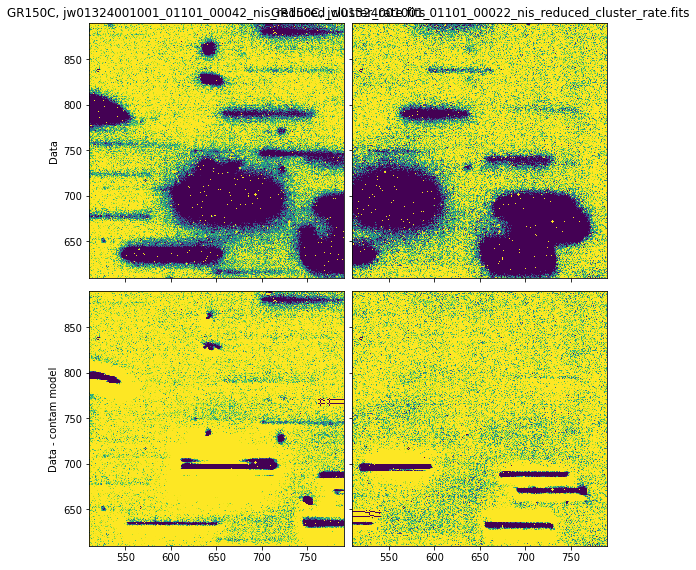

In [14]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.09]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # GR150C

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model , vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[1] 

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

## Extract Individual Spectra <a class="anchor" id="extract-beams"></a>

In [15]:
os.chdir('../Extractions')

In [16]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
print(pline) 

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, 
                                       prior=None,  
                                       pline=pline, 
                                       fit_only_beams=True, 
                                       run_fit=True, 
                                       poly_order=7, 
                                       fsps=True, 
                                       sys_err = 0.03, 
                                       fcontam=0.2, 
                                       zr=[0.05, 3.4], 
                                       save_file='fit_args.yaml')

{'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}
Apply catalog corrections
Compute aperture corrections: i=0, D=0.36" aperture
Compute aperture corrections: i=1, D=0.50" aperture
Compute aperture corrections: i=2, D=0.70" aperture
Compute aperture corrections: i=3, D=1.00" aperture
Compute aperture corrections: i=4, D=1.20" aperture
Compute aperture corrections: i=5, D=1.50" aperture
Compute aperture corrections: i=6, D=3.00" aperture
Apply morphological validity class
Couldn't run morph classification from /Users/victoriastrait/opt/anaconda3/envs/jwst-may10/lib/python3.8/site-packages/grizli/data/sep_catalog_junk.pkl
Write jw01324001001_phot_apcorr.fits
/Users/victoriastrait/opt/anaconda3/envs/jwst-may10/lib/python3.8/site-packages/eazy/data/templates -> ./templates
/Users/victoriastrait/opt/anaconda3/envs/jwst-may10/lib/python3.8/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest
Read default param file: /Users/victoriastrait/opt/anac

ValueError: No valid filters found in jw01324001001_phot_apcorr.fits!  Check that all flux and uncertainty columns are specified / translated correctly.

In [18]:
### Find IDs of specific objects to extract
import astropy.units as u
tab = utils.GTable()
tab['ra'] = [3.6022118, 3.5756968, 3.5803419, 3.5779528, 3.6018804]
tab['dec'] = [-30.3970139, -30.4053504, -30.3921841, -30.4009934, -30.3986601]

idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

idx,ra,dec,id,dr
,deg,deg,,mas
0,3.6022118,-30.3970139,1051,181.9
1,3.5756968,-30.4053504,626,40.0
2,3.5803419,-30.3921841,1282,52.6
3,3.5779528,-30.4009934,846,164.6
4,3.6018804,-30.3986601,965,118.4


### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [19]:
id=source_ids[1]
auto_script.extract(field_root=root, ids=source_ids, 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/5: 1051 6
jw01324001001_01051.beams.fits
1/5: 626 6
jw01324001001_00626.beams.fits
2/5: 1282 4
jw01324001001_01282.beams.fits
3/5: 846 6
jw01324001001_00846.beams.fits
4/5: 965 6
jw01324001001_00965.beams.fits


True

### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

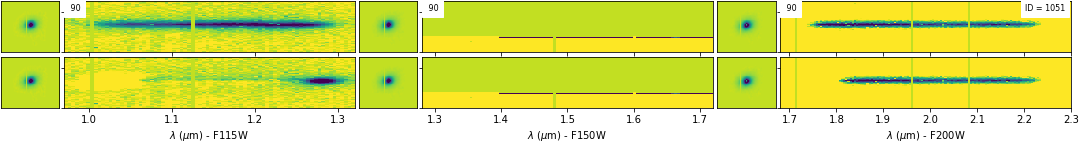

In [20]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, source_ids[0])) 

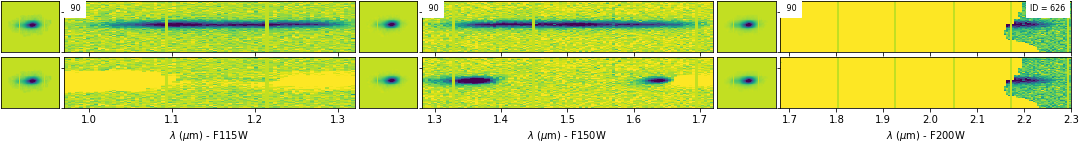

In [21]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, source_ids[1]))

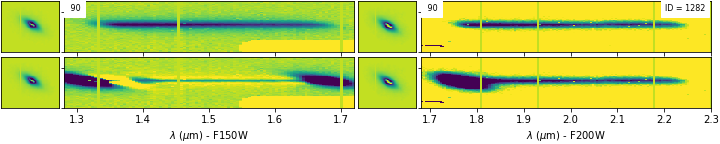

In [22]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, source_ids[2]))

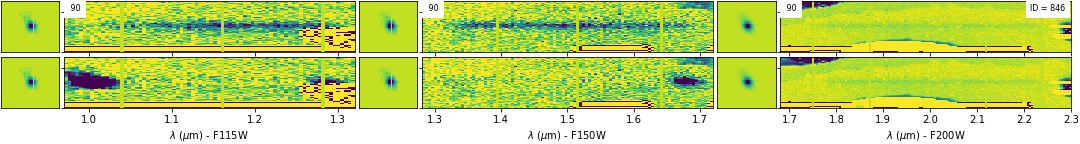

In [23]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, source_ids[3]))

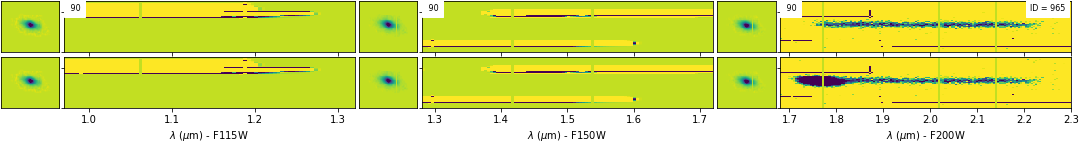

In [24]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, source_ids[4]))

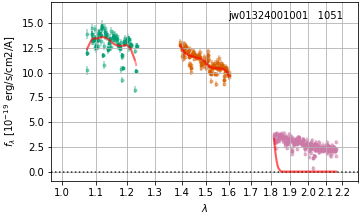

In [25]:
# 1D spectrum with R~30 model
Image(filename='{0}_{1:05d}.R30.png'.format(root, source_ids[0])) 

## Next steps:
* Make sure flat fielding, background subtraction, column averaging, cosmic ray rejection are functional for NIRISS
* After we get real data, tweak relevant values for these things and update flats/background files as they come in
* Enhancing the pipeline with other updates:
    * Make it automatic to download the newest calibration files from CRDS
    * Add more tests of the JWST functionality
    * Add functionality with MIRI and NIRCam
    * Make the code more general in several places to remove hard-coded values for e.g., size of images
    
The JWST functionality is still under heavy development. If you find a bug, please file an issue on the github repo: https://github.com/gbrammer/grizli